In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers

from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Concatenate , Add, Dot, Activation, Lambda
from tensorflow.keras.models import Model

from tensorflow.image import flip_up_down, flip_left_right, rot90
from tensorflow.linalg import normalize

from tensorflow.keras.preprocessing.image import ImageDataGenerator


import matplotlib.pyplot as plt


In [2]:
from tensorflow.python.client import device_lib
#tf.disable_v2_behavior()

#print(device_lib.list_local_devices())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

print(tf.__version__ )

Num GPUs Available:  1
2.9.1


In [3]:
class SymAntiConv2D(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size=(3,3), padding = 'VALID', strides = (1, 1), activation=None, use_bias = True):
        super(SymAntiConv2D, self).__init__()
        self.filters = filters
        self.kernel_size = kernel_size
        self.activation = activation
        self.padding = padding
        self.kernel_initializer = tf.initializers.GlorotUniform(seed=42)
        self.bias_initializer = tf.initializers.Zeros()
        self.strides = strides
        self.use_bias = use_bias
        self.w = None
        self.b = None

    def build(self, input_shape):
        *_, n_channels = input_shape
        self.w = tf.Variable(
            initial_value=self.kernel_initializer(shape=(*self.kernel_size,
                                                         n_channels,
                                                         self.filters),
                                 dtype='float32'), trainable=True)
        
        if self.use_bias:
            self.b_sym = tf.Variable(
                initial_value=self.bias_initializer(shape=(self.filters,), 
                                                    dtype='float32'),
                trainable=True)

            self.b_anti = tf.Variable(
                initial_value=self.bias_initializer(shape=(self.filters,), 
                                                    dtype='float32'),
                trainable=True)

    def call(self, inputs, training=None):

        filters = tf.reshape(self.w, (3,3,self.w.shape[-1]*self.w.shape[-2]))
        mat_flip_x = flip_left_right(filters)
        mat_flip_y = flip_up_down(filters)

        mat_flip_xy = flip_left_right(flip_up_down(filters))

        sum = filters + mat_flip_x + mat_flip_y + mat_flip_xy
        mat_sum_rot_90 = rot90(sum)

        sym_f = (sum + mat_sum_rot_90) / 8
        anti_f = filters-sym_f

        w_sym = tf.reshape(sym_f, self.w.shape)
        w_anti = tf.reshape(anti_f, self.w.shape)

        x_sym =  tf.nn.conv2d(inputs, filters=w_sym, strides=self.strides, 
                          padding=self.padding)
        x_anti = tf.nn.conv2d(inputs, filters=w_anti, strides=self.strides, 
                          padding=self.padding)
        if self.use_bias:
            x_sym = x_sym + self.b_sym
            x_anti = x_anti + self.b_anti

        x_sym = self.activation(x_sym)
        x_anti = self.activation(x_anti)

        return [x_sym, x_anti]


In [7]:
from tkinter import S


input_net = Input((32, 32, 3))

s, a = SymAntiConv2D(filters=32, activation=tf.nn.relu, padding='SAME')(input_net)
s, _ = SymAntiConv2D(filters=32, activation=tf.nn.relu, padding='SAME')(s)
s, _ = SymAntiConv2D(filters=32, activation=tf.nn.relu, padding='SAME')(s)
y = (Concatenate()([s, Lambda(lambda x: tf.math.reduce_max(x, axis=-1 , keepdims=True))(a)]))
y = layers.MaxPooling2D(pool_size=(2, 2))(y) 

s, a = SymAntiConv2D(filters=32, activation=tf.nn.relu, padding='SAME')(y)
s, _ = SymAntiConv2D(filters=32, activation=tf.nn.relu, padding='SAME')(s)
s, _ = SymAntiConv2D(filters=32, activation=tf.nn.relu, padding='SAME')(s)
y = (Concatenate()([s, Lambda(lambda x: tf.math.reduce_max(x, axis=-1 , keepdims=True))(a)]))
y = layers.MaxPooling2D(pool_size=(2, 2))(y) 

s, a = SymAntiConv2D(filters=64, activation=tf.nn.relu, padding='SAME')(y)
s, _ = SymAntiConv2D(filters=32, activation=tf.nn.relu, padding='SAME')(s)
s, _ = SymAntiConv2D(filters=32, activation=tf.nn.relu, padding='SAME')(s)
y = (Concatenate()([s, Lambda(lambda x: tf.math.reduce_max(x, axis=-1 , keepdims=True))(a)]))


y = layers.Flatten()(y)
y = layers.Dense(1024, activation="relu")(y)
output_net  = layers.Dense(100, activation='softmax')(y)

model = Model(inputs = input_net, outputs = output_net)
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 sym_anti_conv2d_9 (SymAntiConv  [(None, 32, 32, 32)  928        ['input_2[0][0]']                
 2D)                            , (None, 32, 32, 32                                               
                                )]                                                                
                                                                                                  
 sym_anti_conv2d_10 (SymAntiCon  [(None, 32, 32, 32)  9280       ['sym_anti_conv2d_9[0][0]']      
 v2D)                           , (None, 32, 32, 32                                         

In [8]:
batch_size = 128
epochs = 5
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer="adam", metrics=["accuracy"])



x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


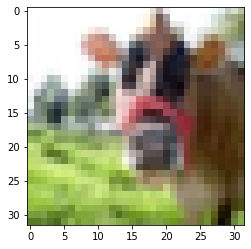

In [9]:
num_classes = 100
input_shape = (32, 32, 3)

# Load the data and split it between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()



# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
#x_train = np.expand_dims(x_train, -1)
#x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

plt.imshow(x_train[0,:,:,:])


In [10]:
def rotateDataset(x,y, maxRot = 360, h=28, w=28, batch_size=100):
    datagen = ImageDataGenerator(rotation_range=maxRot)
    # fit the generator
    datagen.fit(x.reshape(x.shape[0], 32, 32, 3))
    #out = datagen.flow(x.reshape(x.shape[0], h, w, 1), y.reshape(y.shape[0], -1), batch_size=batch_size)

    out = datagen.flow(x.reshape(x.shape[0], h, w, 3),  y.reshape(y.shape[0], -1), batch_size=batch_size)


    return  out

In [11]:
print(y_train.shape)

(50000, 100)


In [12]:
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs) #, validation_data=rotateDataset(x_train, y_train, h=32, w=32))


Epoch 1/5
391/391 [==============================] - 49s 99ms/step - loss: 4.0930 - accuracy: 0.0641
Epoch 2/5
391/391 [==============================] - 38s 96ms/step - loss: 3.6292 - accuracy: 0.1376
Epoch 3/5
391/391 [==============================] - 38s 97ms/step - loss: 3.3659 - accuracy: 0.1861
Epoch 4/5
391/391 [==============================] - 38s 97ms/step - loss: 3.1628 - accuracy: 0.2257
Epoch 5/5
200/391 [==============>...............] - ETA: 19s - loss: 3.0102 - accuracy: 0.2537

KeyboardInterrupt: 

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]]
1/1 [==============================] - 0s 27ms/step
82 82
(1, 8, 8, 33)
(1, 32, 32, 3)


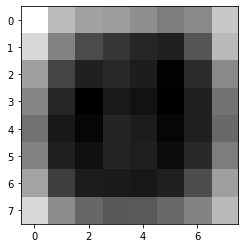

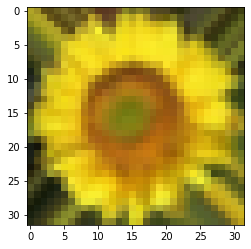

In [35]:
get_layer_output = K.function([model.input], model.layers[-1].output)

for X,Y in rotateDataset(x_test,y_test, batch_size=1, h=32, w=32, maxRot=360):
    print(Y)
    print(np.argmax(Y), np.argmax(model.predict(X)))
    #plt.imshow(X.reshape(28,28), cmap='gray_r')  
    plt.figure(1)  

    get_layer_output = K.function([model.input], model.layers[-4].output)
    layer_out = np.array(get_layer_output([X]))
    print(layer_out.shape)
    plt.imshow(np.mean(layer_out[0,:,:,:], axis=-1),  cmap='gray_r')   
    #plt.figure(2) 

    #print(layer_out[0, :, : ,1 ].shape)
    #plt.imshow(layer_out[0, :, : ,1 ],  cmap='gray_r')

    plt.figure(3) 

    print(X.shape)
    plt.imshow(X[0],  cmap='gray_r')
    break

In [ ]:
print(layer_out[0, :, :,:].shape)
yy =  tf.math.reduce_sum(layer_out[0, :, :, :], axis=-1, keepdims=True)
yy.shape


(7, 7, 64)


TensorShape([7, 7, 1])